In [1]:
import os

import cv2
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.utils.data as data
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as F
from torchvision.ops import box_iou
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from torch import optim
from torchmetrics.detection import IntersectionOverUnion
from torchvision import tv_tensors
from torchvision.io import decode_image, ImageReadMode
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
ANNOTATIONS_FOLDER = os.path.join('.', 'dataset', 'annotations')
IMAGES_FOLDER = os.path.join('.', 'dataset', 'images')
OUTPUT_FOLDER = os.path.join('.', 'output')

In [3]:
import sys
import logging

logger = logging.getLogger('Faster R-CNN training')

if logger.hasHandlers():
    logger.handlers.clear()
    
logger.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter(
    '%(asctime)s %(levelname)-5s %(name)s - %(message)s',
)
handler.setFormatter(formatter)

logger.addHandler(handler)

In [4]:
import re

annotations_paths = sorted(
    [os.path.join(ANNOTATIONS_FOLDER, xml_name) for xml_name in os.listdir(ANNOTATIONS_FOLDER)], 
    key=lambda x: int(re.search(r'\d+', x).group())
)

In [5]:
import xml.etree.ElementTree as ET

parsed_annotations = []

for xml_path in annotations_paths:
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    filename = root.find('filename').text
    
    size_node = root.find('size')
    width = int(size_node.find('width').text)
    height = int(size_node.find('height').text)
    
    object_node = root.find('object')
    bnd_node = object_node.find('bndbox')
    
    ymin = int(bnd_node.find('ymin').text)
    xmin = int(bnd_node.find('xmin').text)
    ymax = int(bnd_node.find('ymax').text)
    xmax = int(bnd_node.find('xmax').text)
    
    annotation_data = {
        'image_name': filename,
        'width': width,
        'height': height,
        'ymin': ymin,
        'xmin': xmin,
        'ymax': ymax,
        'xmax': xmax
    }
    
    parsed_annotations.append(annotation_data)
    
df = pd.DataFrame(parsed_annotations)

In [6]:
df.head(10)

image_name  width  height  ymin  xmin  ymax  xmax
0  Cars0.png    500     268   125   226   173   419
1  Cars1.png    400     248   128   134   160   262
2  Cars2.png    400     400   176   229   193   270
3  Cars3.png    400     225   128   142   157   261
4  Cars4.png    590     350    82   156   253   503
5  Cars5.png    400     295   218   226   240   242
6  Cars6.png    500     375   114   112   239   373
7  Cars7.png    400     279   141   166   154   206
8  Cars8.png    500     232   104   204   134   304
9  Cars9.png    442     333   224   164   247   272

(-0.5, 441.5, 332.5, -0.5)

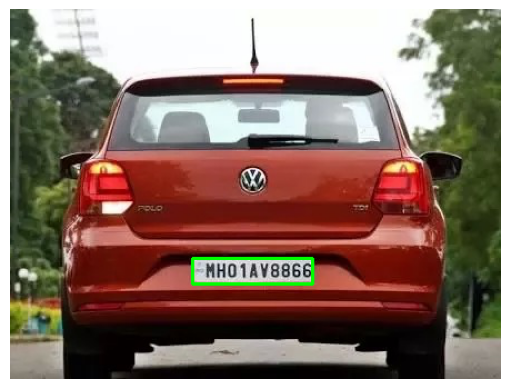

In [7]:
sample_image_row = df.iloc[9]

sample_image = cv2.imread(os.path.join(IMAGES_FOLDER, sample_image_row['image_name']))
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

ymin = sample_image_row['ymin']
xmin = sample_image_row['xmin']
ymax = sample_image_row['ymax']
xmax = sample_image_row['xmax']

cv2.rectangle(sample_image_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(sample_image_rgb)
plt.axis('off')

In [8]:
class CarPlatesDataset(data.Dataset):
    def __init__(self, df_annotations, images_folder=IMAGES_FOLDER, transforms=None):
        self.df_annotations = df_annotations
        self.images_folder = images_folder
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_annotations)
    
    def __getitem__(self, index):
        item_row = self.df_annotations.iloc[index]
        item_image_path = os.path.join(self.images_folder, item_row['image_name'])
        
        image = decode_image(item_image_path, mode=ImageReadMode.RGB)
        xmin = item_row['xmin']
        ymin = item_row['ymin']
        xmax = item_row['xmax']
        ymax = item_row['ymax']
        
        boxes = [[xmin, ymin, xmax, ymax]]
        image = tv_tensors.Image(image)
        
        target = {
            'boxes': tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=F.get_size(image)),
            'labels': torch.ones((len(boxes),), dtype=torch.int64),
        }
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target  

In [9]:
class CarPlatesDataModule(L.LightningDataModule):
    def __init__(self, df_annotations, batch_size, n_workers=0):
        super().__init__()
        self.df_annotations = df_annotations
        self.batch_size = batch_size
        self.n_workers = n_workers
        self.test_batch_size = 40
        
    def setup(self, stage):
        train_dataset = CarPlatesDataset(self.df_annotations, transforms=self.get_transforms())
        val_dataset = CarPlatesDataset(self.df_annotations, transforms=self.get_transforms())
        test_dataset = CarPlatesDataset(self.df_annotations, transforms=self.get_transforms())
        
        train_indices, test_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)
        train_indices, val_indices = train_test_split(train_indices, test_size=0.1, random_state=24)
        
        self.train_dataset = data.Subset(train_dataset, train_indices)
        self.val_dataset = data.Subset(val_dataset, val_indices)
        self.test_dataset = data.Subset(test_dataset, test_indices)
        
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))
    
    @staticmethod
    def get_transforms():   
        return T.Compose([
            T.ToDtype(torch.float32, scale=True), 
            T.ToPureTensor()
        ])
        
    def train_dataloader(self):
        return data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.n_workers,
            shuffle=True,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.n_workers,
            collate_fn=self.collate_fn
        )

    def test_dataloader(self):
        return data.DataLoader(
            self.test_dataset,
            batch_size=self.test_batch_size,
            num_workers=self.n_workers,
            collate_fn=self.collate_fn
        )

In [10]:
class CustomFasterRCNNModel(L.LightningModule):
    def __init__(self, num_classes=2):
        super().__init__()
        
        model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
        self.model = model
        self.iou_metric = IntersectionOverUnion()
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': lr_scheduler, 'interval': 'epoch', 'frequency': 1},
        }
        
    def forward(self, images, targets):
        return self.model(images, targets)    
    
    def training_step(self, batch):
        images, targets = batch
        losses = self(images, targets)
        result_loss = sum(losses.values())
        self.log('loss', result_loss)
        
        return result_loss

    def validation_step(self, batch):
        images, targets = batch
        output = self(images, targets)

        iou = self.iou_metric(output, targets)['iou']

        self.log_dict({'iou': iou})  
        
    def test_step(self, batch, batch_idx):
        if batch_idx > 0:
            return None
        
        images, targets = batch
        iou_values = []
        
        plt.figure(figsize=(20, 40))
        
        for i in range(len(images)):
            image, target = images[i], targets[i]
            res = self.model([image], [target])
            iou = 0.0
            
            for _, result in zip([image], res):
                boxes_idx = torch.argwhere(result['scores'] > 0.5).flatten()
                boxes = result['boxes'][boxes_idx].long()
                image = (image.cpu().permute(1, 2, 0).numpy() * 255).astype('uint8')
                
                iou = self._compute_iou_per_image(boxes, target['boxes'])
                
                for xmin, ymin, xmax, ymax in boxes:
                    xmin, ymin, xmax, ymax = xmin.item(), ymin.item(), xmax.item(), ymax.item()
                    
                    image = cv2.rectangle(
                        image,
                        (xmin, ymin), (xmax, ymax),
                        (0, 255, 0),
                        2
                    )
            
            iou_values.append(iou)
            
            plt.subplot(10, 5, i + 1)
            plt.axis('off')
            plt.imshow(image)
            plt.title(f'IoU={iou:.3f}')
            
        print(f'Average IoU: {sum(iou_values) / len(iou_values):.3f}')
            
    def _compute_iou_per_image(self, pred_boxes, target_boxes):
        if len(pred_boxes) == 0 or len(target_boxes) == 0:
            return 0.0
    
        ious = box_iou(pred_boxes, target_boxes)
        max_ious, _ = ious.max(dim=1)
        mean_iou = max_ious.mean().item()
        
        return mean_iou

In [11]:
n_epochs = 5
batch_size = 1

In [12]:
model = CustomFasterRCNNModel()
datamodule = CarPlatesDataModule(df, batch_size)

In [13]:
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor='iou', mode='max')
trainer = L.Trainer(
    max_epochs=n_epochs,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback]
)


trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | FasterRCNN            | 43.3 M | train
1 | iou_metric | IntersectionOverUnion | 0      | train
-------------------------------------------------------------
43.0 M    Trainable params
225 K     Non-trainable params
43.3 M    Total params
173.025   Total estimated model params size (MB)
218       Modules in train mode
0         Mo

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s]

C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\.venv\lib\site-packages\lightning\pytorch\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 311/311 [02:13<00:00,  2.33it/s, v_num=45]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 311/311 [02:13<00:00,  2.33it/s, v_num=45]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 311/311 [02:12<00:00,  2.34it/s, v_num=45]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 311/311 [02:13<00:00,  2.34it/s, v_num=45]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 311/311 [02:12<00:00,  2.34it/s, v_num=45]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 311/311 [02:20<00:00,  2.22it/s, v_num=45]    

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 311/311 [02:20<00:00,  2.22it/s, v_num=45]


In [14]:
torch.save(model, os.path.join(OUTPUT_FOLDER, 'model_faster_r_cnn.pt'))

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Average IoU: 0.723


[{}]

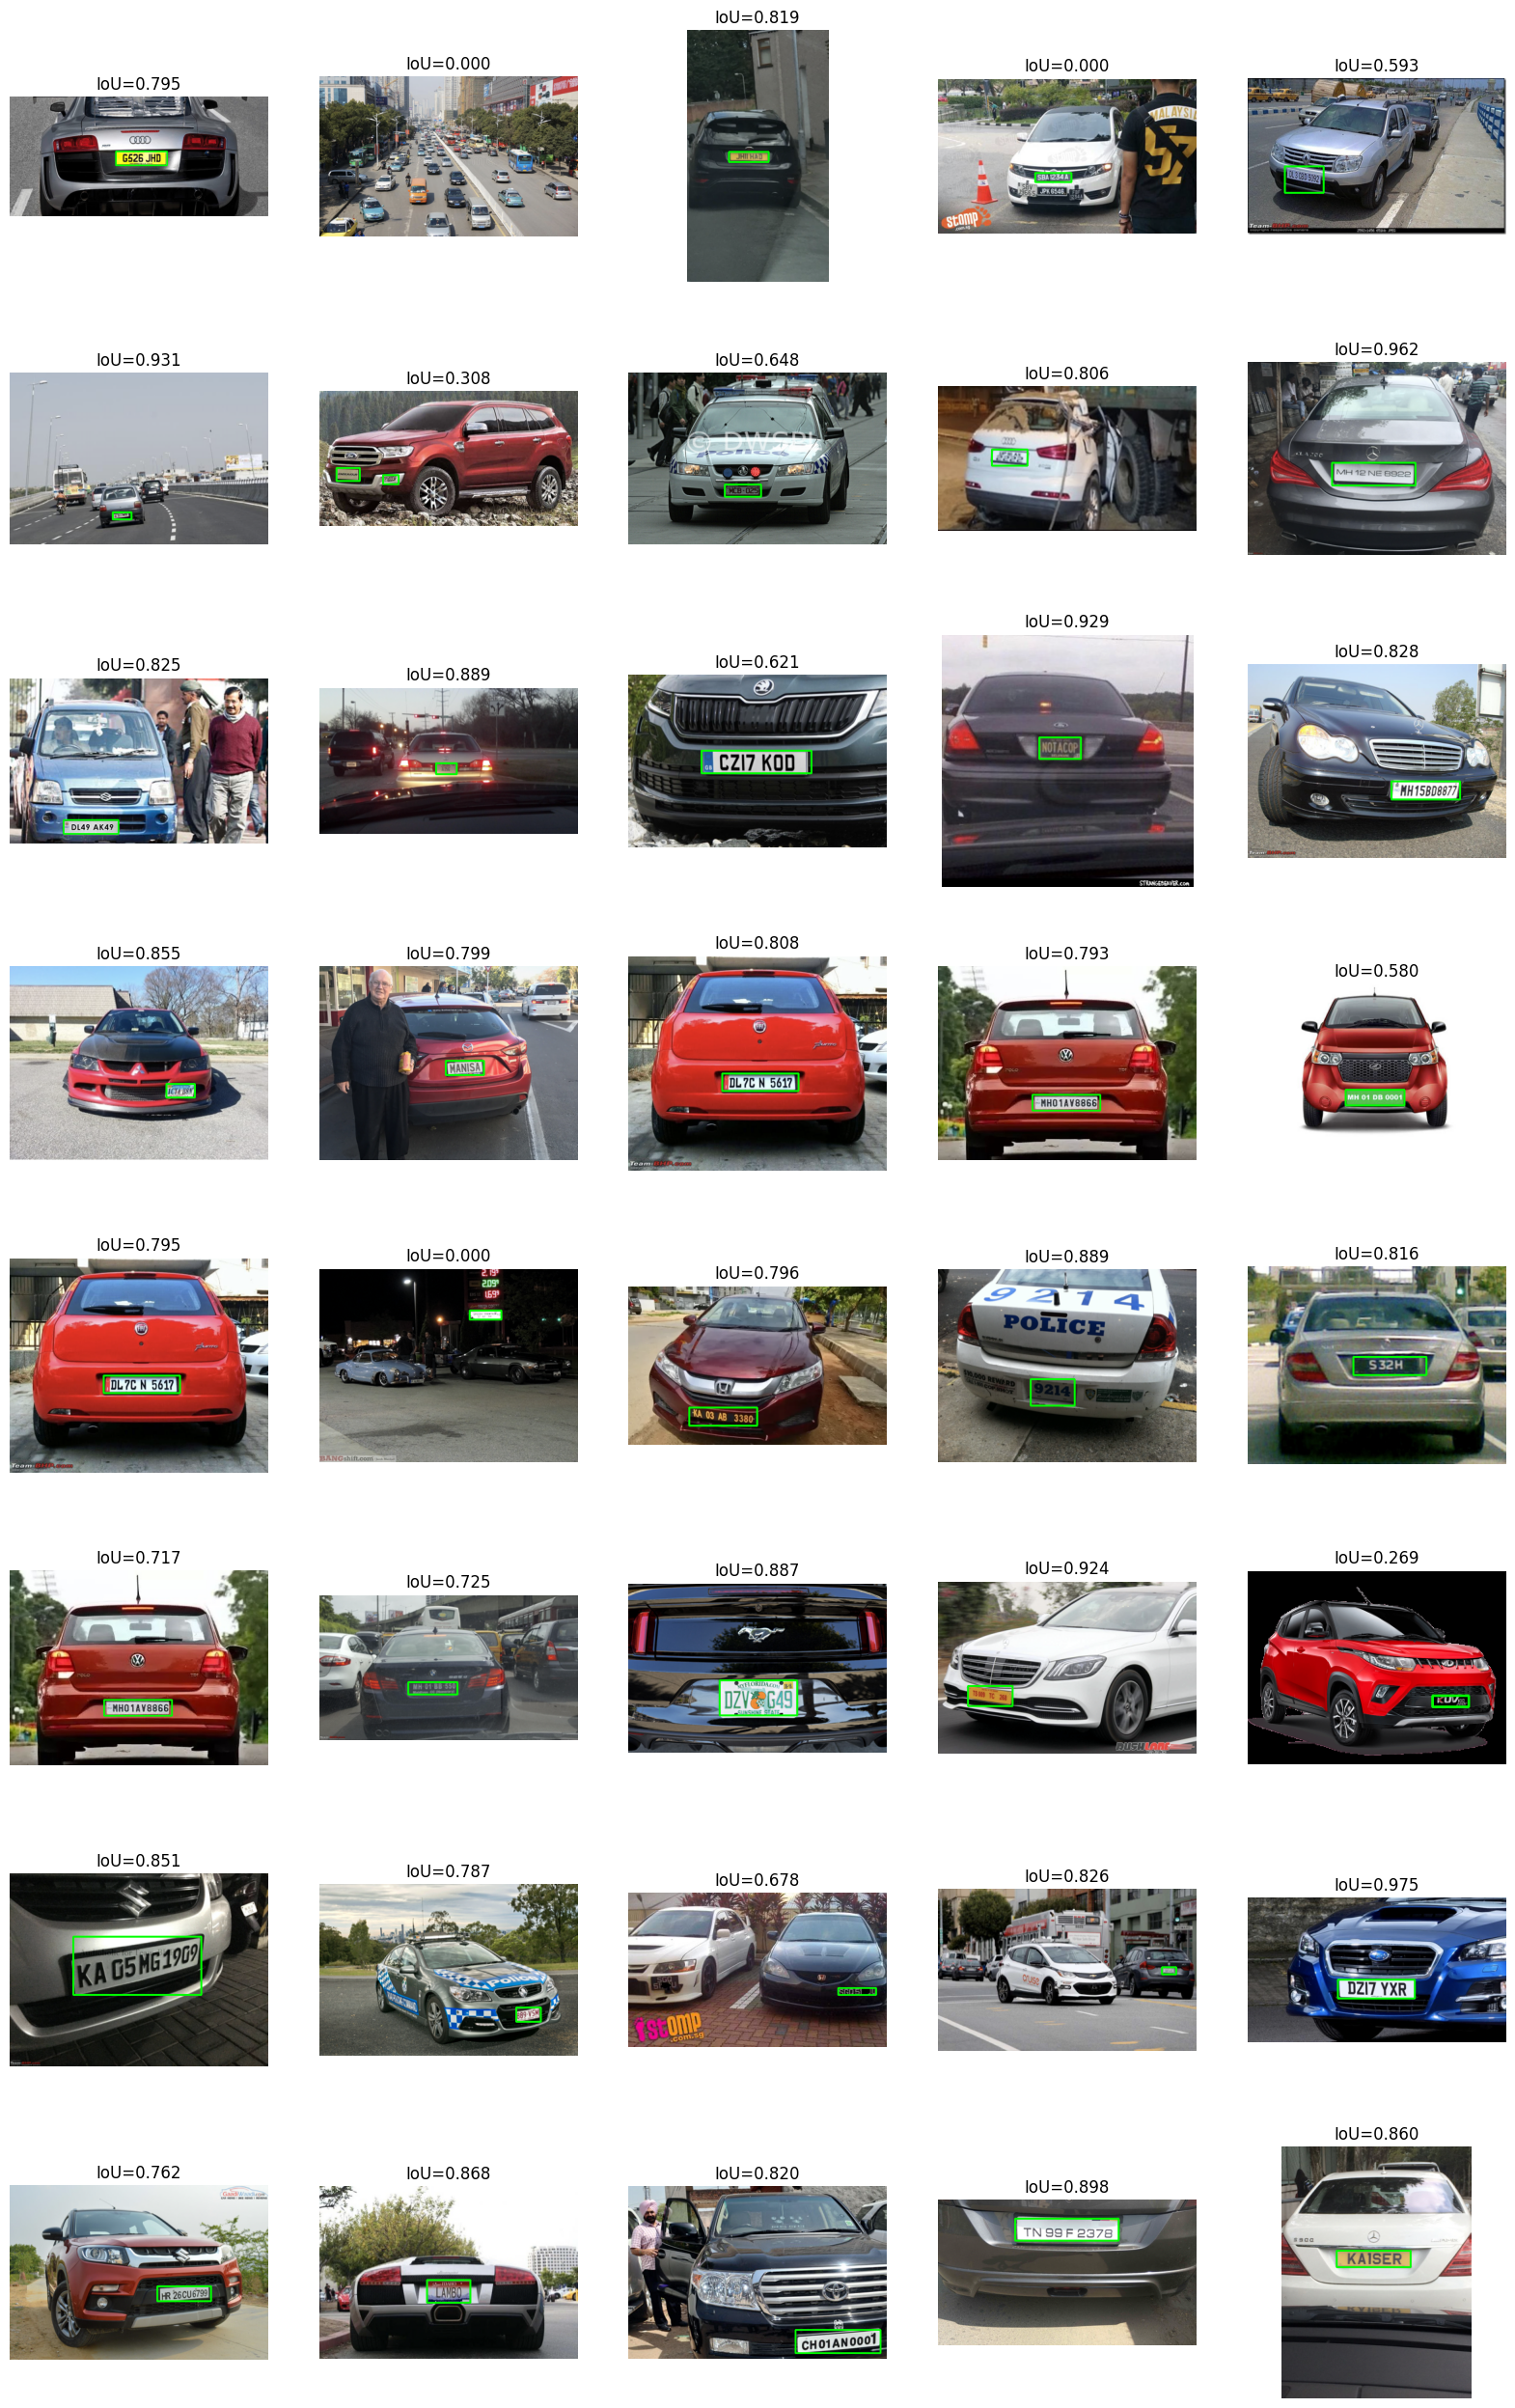

In [15]:
trainer = L.Trainer(enable_progress_bar=False, logger=False)
trainer.test(model, datamodule=datamodule)